<h2>Random Forest Model<h2>

In [37]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.combine import SMOTEENN

In [38]:
df_num = pd.read_csv('./df_num.csv')
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   PaperlessBilling                       7043 non-null   int64  
 6   MonthlyCharges                         7043 non-null   float64
 7   TotalCharges                           7043 non-null   float64
 8   Churn                                  7043 non-null   int64  
 9   gender_Male                            7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   int64  
 11  Mult

In [39]:
print(df_num.isnull().sum())

SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
gender_Male                              0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV

<h2>Correlation Matrix all Features</h2>

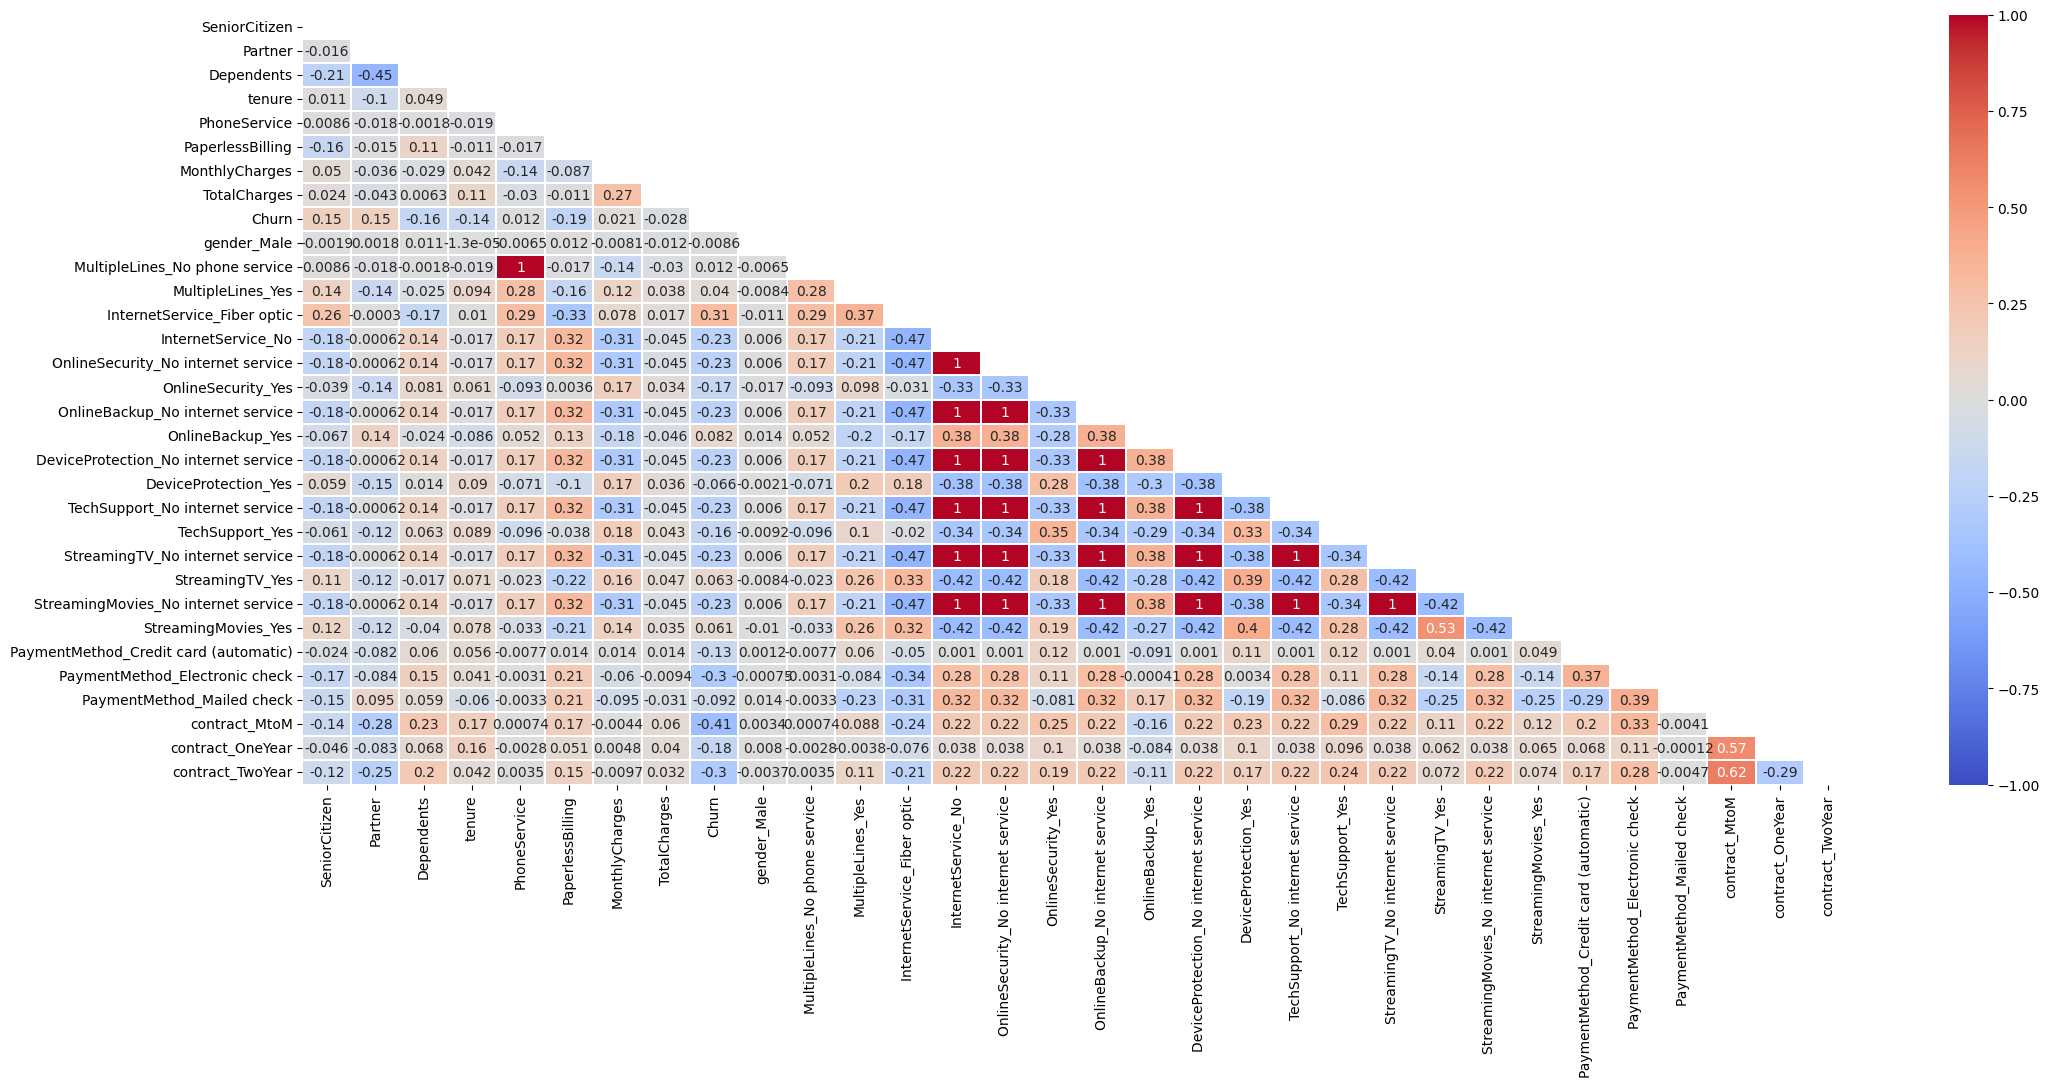

In [40]:
plt.figure(figsize=(25, 10))
corr = df_num.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

There is collinearity between some Features, we see, that by not having internet service, all added online services show the same repeated data. <br><br>
StreamingMovies_No Internet service<br>
StreamingTV_No internet service<br>
TechSupport_No internet service<br>
DeviceProtection_No internet service<br>
OnlineBackup_No internet service<br>
OnlineSecurity_No internet service<br>
<br><br>
MultipleLines_No phone service, on the other hand, shows collinearity with the feature PhoneService.
<br><br>
This will be taken into account when training the models.

In [41]:
columns_to_drop = [
    'StreamingMovies_No internet service',
    'StreamingTV_No internet service',
    'TechSupport_No internet service',
    'DeviceProtection_No internet service',
    'OnlineBackup_No internet service',
    'OnlineSecurity_No internet service',
    'MultipleLines_No phone service'
]

# Eliminar las columnas del DataFrame
df_num = df_num.drop(columns=columns_to_drop)

# Verificar que las columnas han sido eliminadas
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   PaperlessBilling                       7043 non-null   int64  
 6   MonthlyCharges                         7043 non-null   float64
 7   TotalCharges                           7043 non-null   float64
 8   Churn                                  7043 non-null   int64  
 9   gender_Male                            7043 non-null   int64  
 10  MultipleLines_Yes                      7043 non-null   int64  
 11  Inte

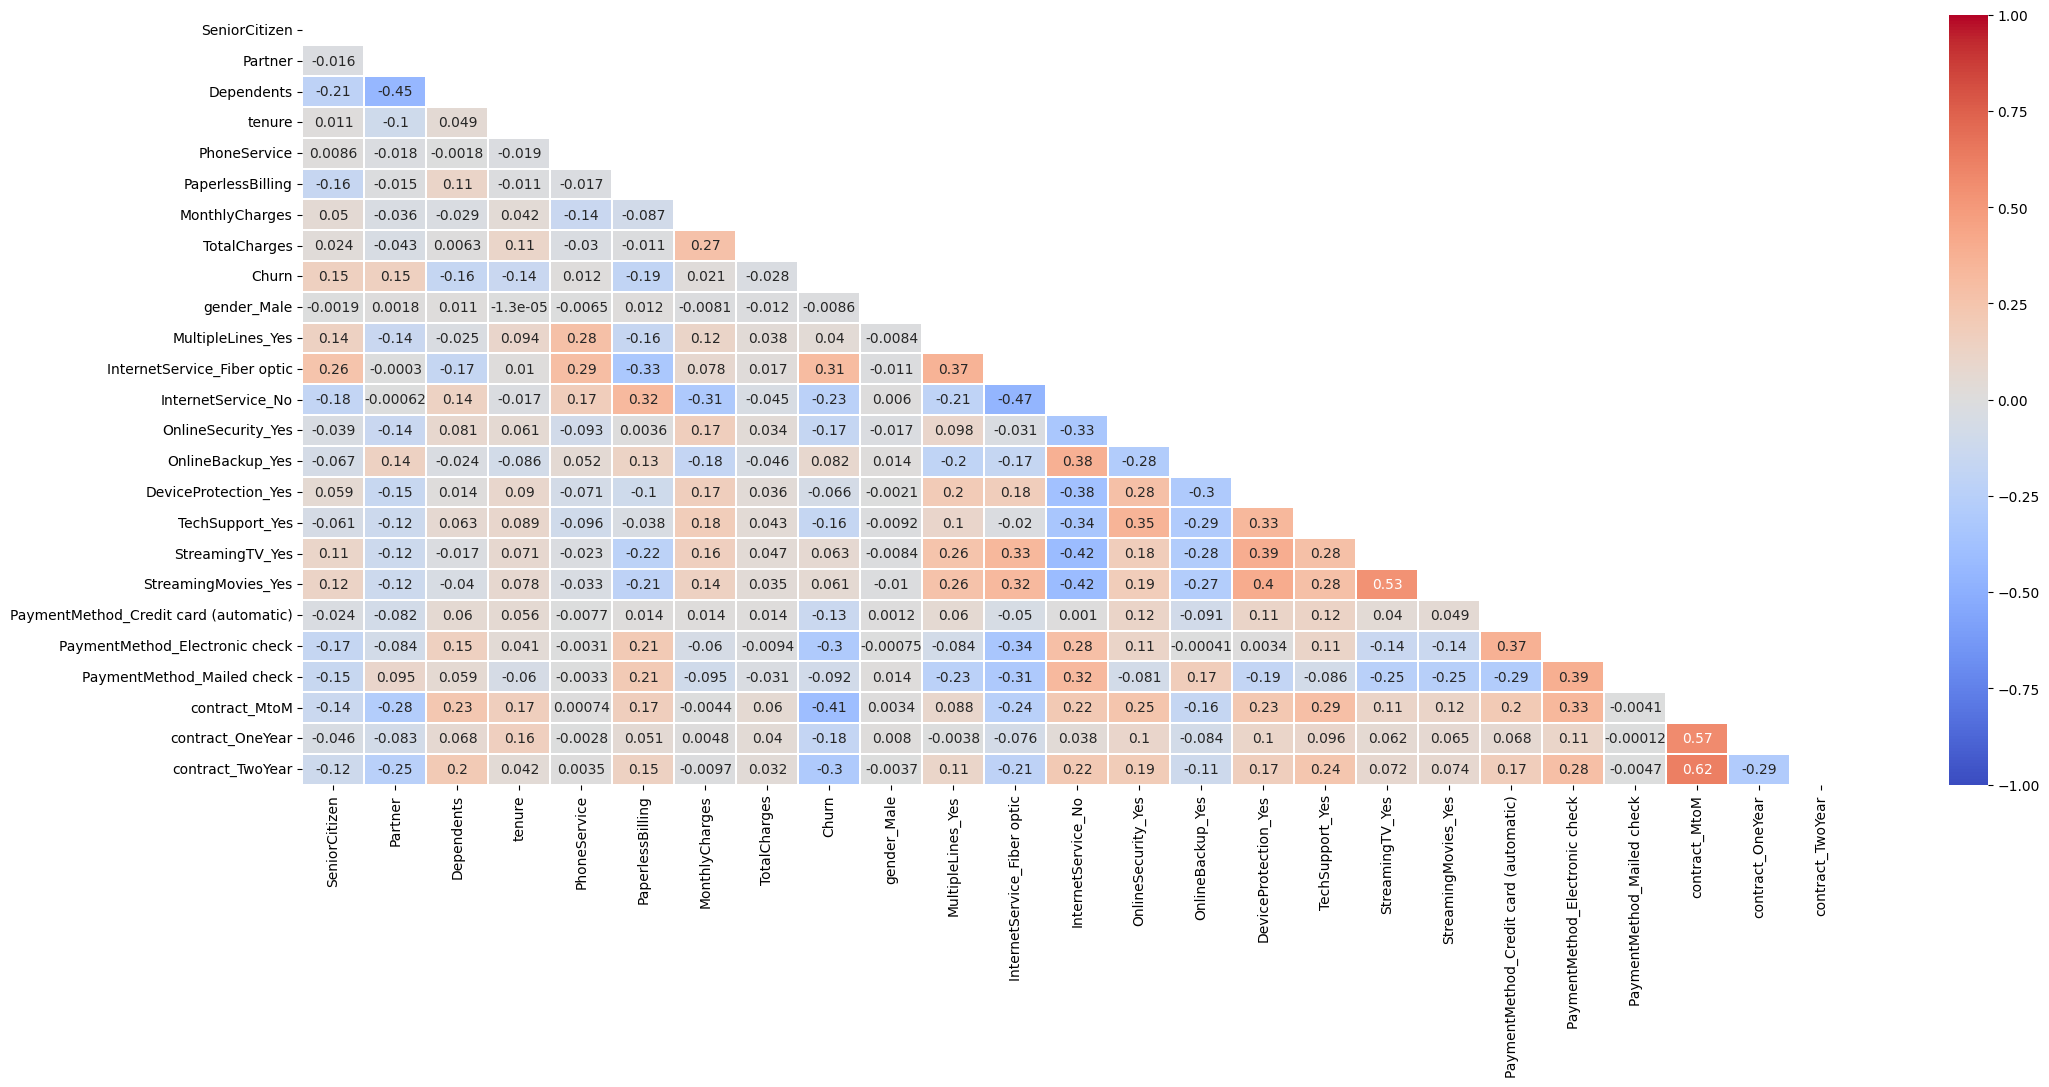

In [42]:
plt.figure(figsize=(25, 10))
corr = df_num.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

<h2>Random Forest & Features Importance</h2>

#### Model 1

In [43]:
# Model 1 preparation
X = df_num.drop(columns=['Churn'])
y = df_num['Churn']

In [44]:
correlations_with_target = X.corrwith(y)
print(correlations_with_target.sort_values(ascending=False))

contract_MtoM                            0.405103
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
gender_Male                             -0.008612
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226
contract_OneYear                        -0.177820


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
model1 = RandomForestClassifier(n_estimators=1000, random_state=42)
model1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [47]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model1.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

                                  Feature  Importance
7                            TotalCharges    0.182142
6                          MonthlyCharges    0.171455
3                                  tenure    0.157688
21                          contract_MtoM    0.064010
10            InternetService_Fiber optic    0.039744
19         PaymentMethod_Electronic check    0.037753
8                             gender_Male    0.029074
5                        PaperlessBilling    0.027799
12                     OnlineSecurity_Yes    0.023841
1                                 Partner    0.023366
13                       OnlineBackup_Yes    0.021972
15                        TechSupport_Yes    0.021376
9                       MultipleLines_Yes    0.020969
14                   DeviceProtection_Yes    0.020382
23                       contract_TwoYear    0.020308
0                           SeniorCitizen    0.020195
2                              Dependents    0.019890
17                    Stream

In [48]:
y_test_pred = model1.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model1.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = model1.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1385  167]
 [ 283  278]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.50      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113

Train Score: 0.9980
Test Score: 0.7870
Difference (Train - Test): 0.2109
ROC-AUC: 0.6940


Select the most important features for our first MVP model: <br><br>
TotalCharges    0.193621<br>
MonthlyCharges    0.170403<br>
tenure    0.163847<br>
contract_MtoM<br>

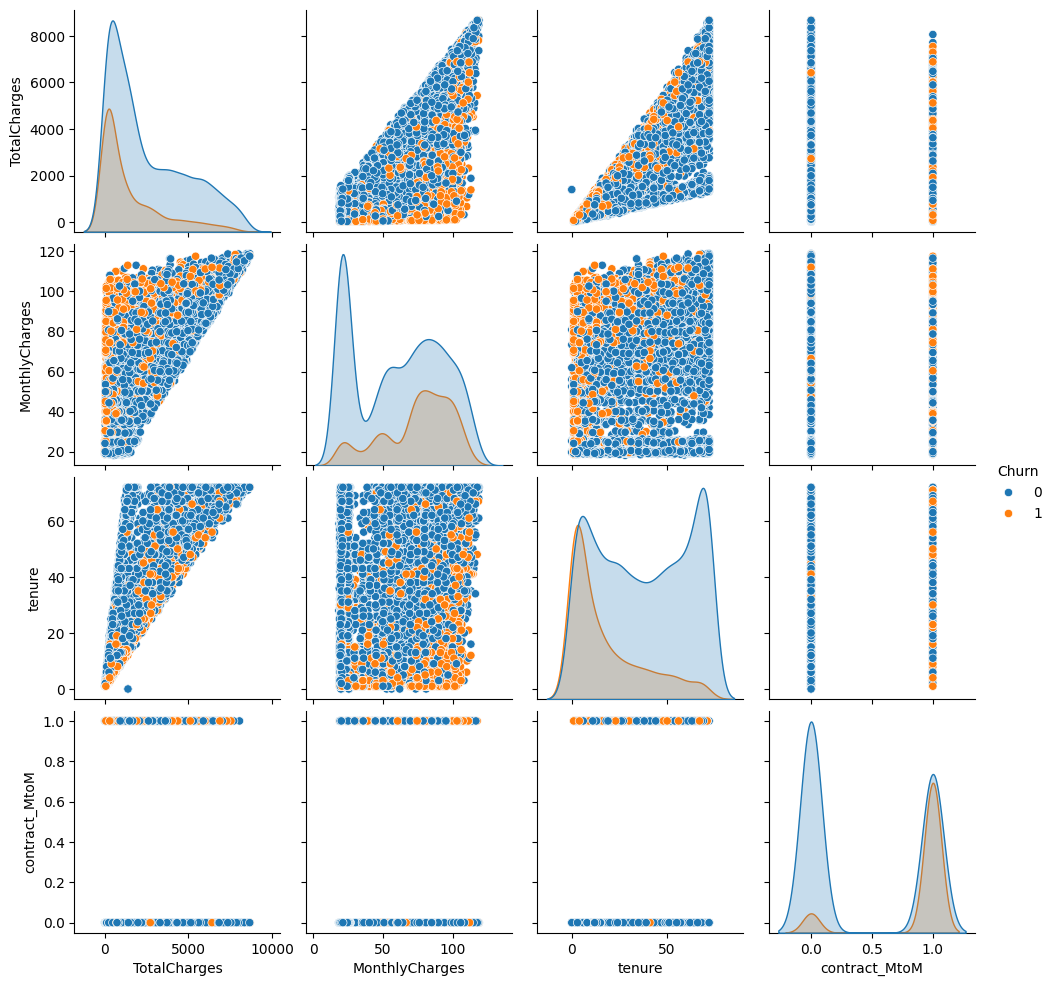

In [49]:
# Selecting the 4 most important features and the target variable
df_selected = df_num[['TotalCharges', 'MonthlyCharges', 'tenure', 'contract_MtoM', 'Churn']]

sns.pairplot(df_selected, hue='Churn', diag_kind='kde')  # diag_kind='kde' para suavizar las distribuciones
plt.show()

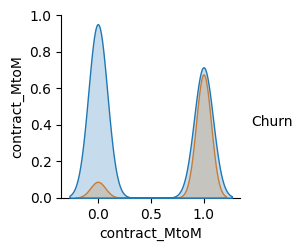

In [ ]:
df_s = df_num[[ 'contract_MtoM', 'Churn']]

sns.pairplot(df_s, hue='Churn', diag_kind='kde')  # diag_kind='kde' para suavizar las distribuciones
plt.show()

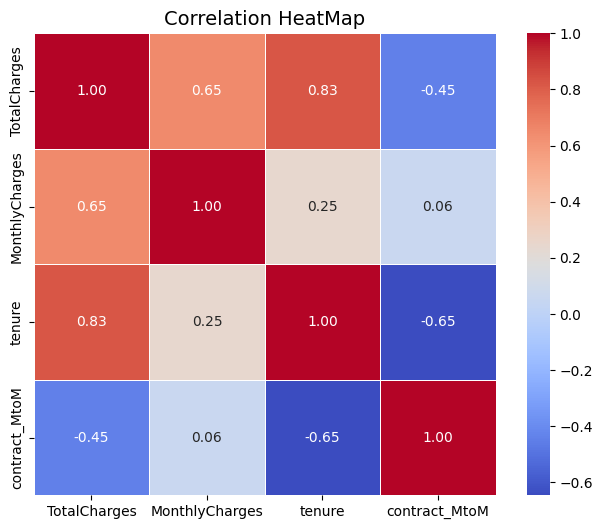

In [50]:
# Selecting the 4 most important features
df_selected = df_num[['TotalCharges', 'MonthlyCharges', 'tenure', 'contract_MtoM']]

# Correlation Matrix
correlation_matrix = df_selected.corr()

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,  
    fmt=".2f",  
    cmap="coolwarm", 
    square=True, 
    linewidths=0.5, 
)

plt.title("Correlation HeatMap", fontsize=14)
plt.show()

The contracts that are renewed on a month-to-month basis have a strong correlation with the loyalty of our customers and the business as well as with Total Charges, and we also appreciate that loyalty has a high correlation with Total Charges.

In [51]:
print(df_num[['TotalCharges', 'MonthlyCharges','contract_MtoM','contract_OneYear', 'contract_TwoYear']].head())
print(df_num[['TotalCharges', 'MonthlyCharges']].describe())

   TotalCharges  MonthlyCharges  contract_MtoM  contract_OneYear  \
0         29.85           29.85              1                 0   
1       1889.50           56.95              0                 1   
2        108.15           53.85              1                 0   
3       1840.75           42.30              0                 1   
4        151.65           70.70              1                 0   

   contract_TwoYear  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
       TotalCharges  MonthlyCharges
count   7043.000000     7043.000000
mean    2281.916928       64.761692
std     2265.270398       30.090047
min       18.800000       18.250000
25%      402.225000       35.500000
50%     1397.475000       70.350000
75%     3786.600000       89.850000
max     8684.800000      118.750000


It seems that the MonthlyCharges feature only covers the last month's payment or a specific service, because considering the duration of the contract, the amounts do not fit.

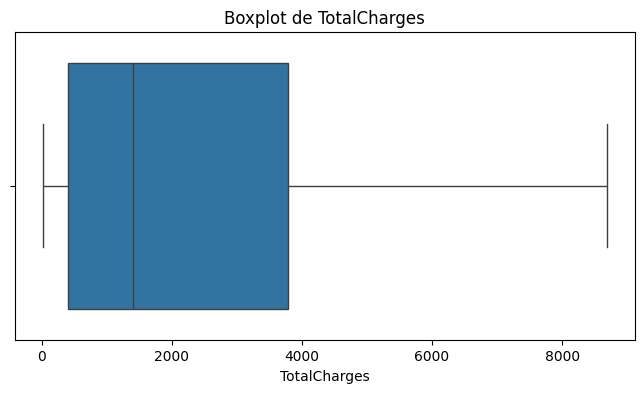

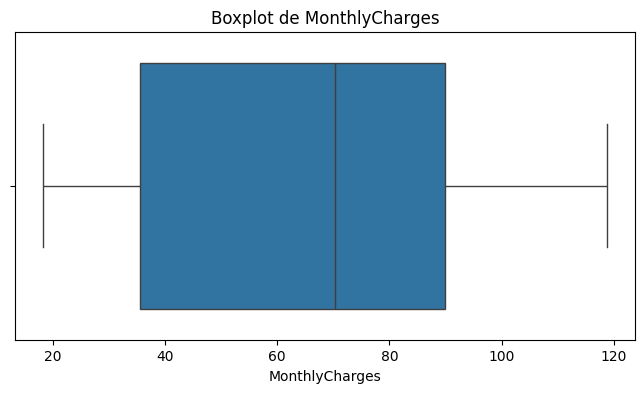

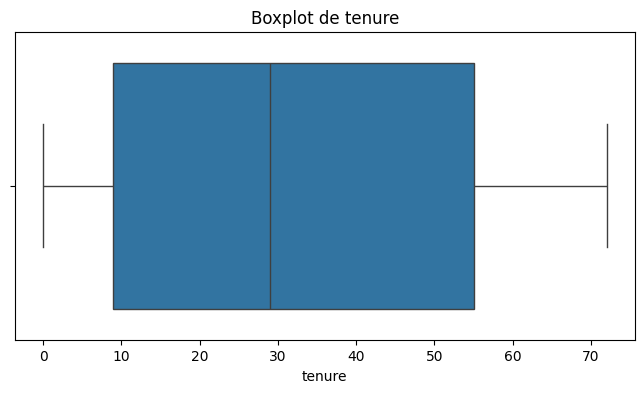

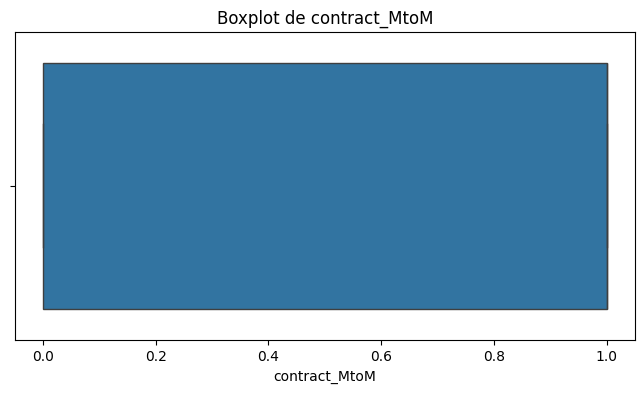

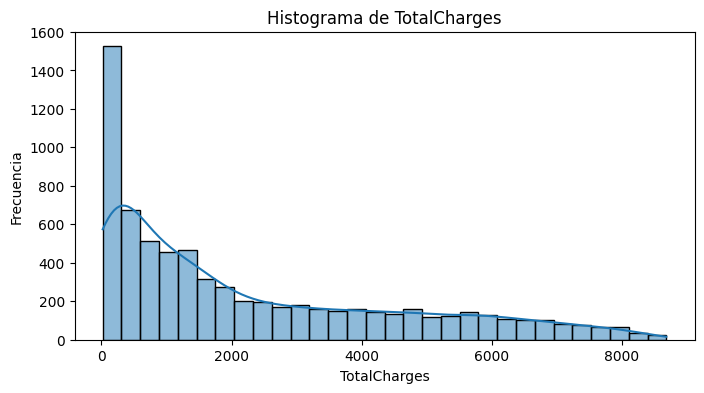

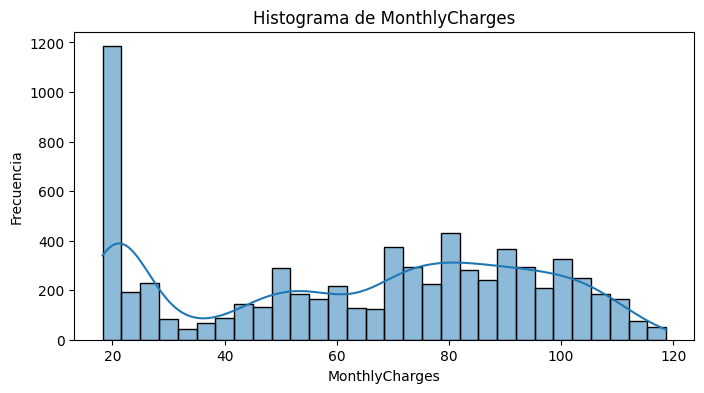

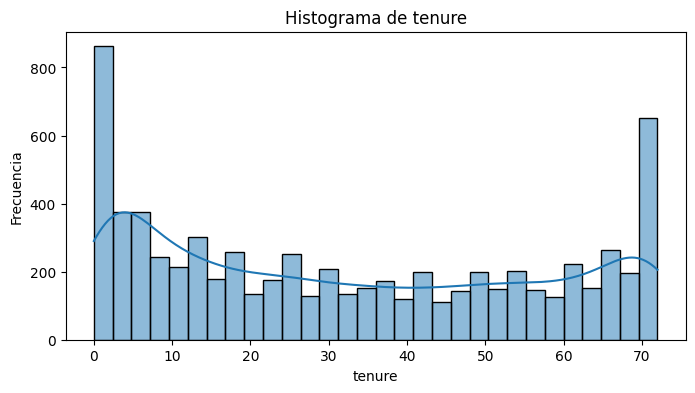

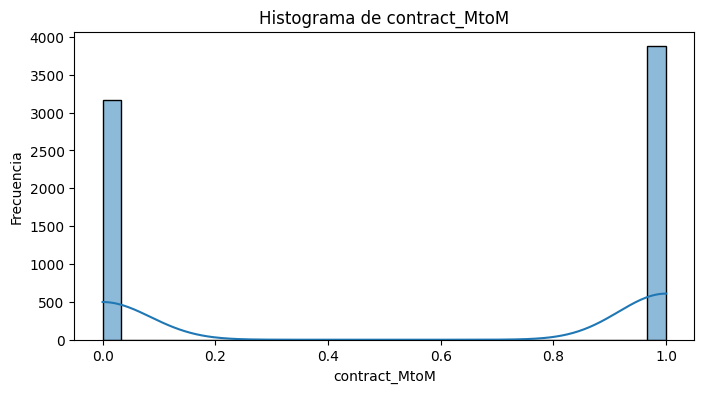

In [52]:
# Let's look at whether there are outliers in the main features.
for feature in df_selected.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_selected[feature])
    plt.title(f'Boxplot de {feature}')
    plt.xlabel(feature)
    plt.show()


for feature in df_selected.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_selected[feature], kde=True, bins=30)
    plt.title(f'Histograma de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.show()

The MonthlyCharges and TotalCharges feature have a non-uniform distribution where, depending on the case, we will have to apply a logarithmic transformation.

#### Model 2

In [53]:
X = df_num.drop(columns=['Churn']) # All the dataframe
y = df_num['Churn']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [55]:
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X_train: (4930, 24)
Dimensiones de X_test: (2113, 24)
Dimensiones de y_train: (4930,)
Dimensiones de y_test: (2113,)


In [56]:
model2 = RandomForestClassifier(n_estimators=50, random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [57]:
y_test_pred = model2.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model2.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = model2.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1387  165]
 [ 297  264]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1552
           1       0.62      0.47      0.53       561

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.70      2113
weighted avg       0.77      0.78      0.77      2113

Train Score: 0.9978
Test Score: 0.7814
Difference (Train - Test): 0.2164
ROC-AUC: 0.6821


Models with the full dataframe work better, so we will keep that pattern.

#### Model 3

In [58]:
X = df_num.drop(columns=['Churn'])
y = df_num['Churn']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [60]:
# We will try some hiperparameters with an RandomSearchCV to aprox a better fitting.
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [2, 3, 4, 6, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

In [61]:
model3 = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_dist,
    n_iter=50,
    scoring='precision',
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [2, 3, 4, 6, 7],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, scoring='precision')

In [62]:
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 2, 'class_weight': None}


In [63]:
y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = best_model.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = best_model.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1542   10]
 [ 495   66]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1552
           1       0.87      0.12      0.21       561

    accuracy                           0.76      2113
   macro avg       0.81      0.56      0.53      2113
weighted avg       0.79      0.76      0.69      2113

Train Score: 0.7554
Test Score: 0.7610
Difference (Train - Test): -0.0056
ROC-AUC: 0.5556


### Model 4

In [64]:
# GridSearch to acurate more the hiperparameters.
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 200, 500],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 9],
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced']
}

In [65]:
model4GS = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

In [66]:
model4GS.fit(X_train, y_train)
print("Best Parameters:", model4GS.best_params_)
model4 = model4GS.best_estimator_

Best Parameters: {'class_weight': None, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}


In [67]:
# Extract results
results = pd.DataFrame(model4GS.cv_results_)

# Select relevant columns
results = results[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
     'mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score']
]

# Sort by validation score
results = results.sort_values(by='mean_test_score', ascending=False)
results

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score,std_train_score,std_test_score
3,500,3,5,5,0.740156,0.730678,0.006108,0.035907
7,500,3,10,5,0.740156,0.730678,0.006108,0.035907
11,500,3,5,9,0.739752,0.730678,0.005695,0.035907
15,500,3,10,9,0.739752,0.730678,0.005695,0.035907
2,200,3,5,5,0.736016,0.728937,0.006739,0.034412
...,...,...,...,...,...,...,...,...
77,100,3,10,9,0.494036,0.492635,0.006331,0.025014
69,100,3,10,5,0.493467,0.492536,0.006825,0.025786
65,100,3,5,5,0.493467,0.492536,0.006825,0.025786
74,200,3,5,9,0.494021,0.492253,0.006850,0.024734


In [68]:
y_test_pred = model4.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model4.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = model4.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1492   60]
 [ 407  154]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      1552
           1       0.72      0.27      0.40       561

    accuracy                           0.78      2113
   macro avg       0.75      0.62      0.63      2113
weighted avg       0.77      0.78      0.74      2113

Train Score: 0.7870
Test Score: 0.7790
Difference (Train - Test): 0.0080
ROC-AUC: 0.6179


### Model 5

In [69]:
model5 = RandomForestClassifier(n_estimators= 500, min_samples_split= 2, 
                                min_samples_leaf= 4, max_features= 'sqrt', 
                                max_depth= 5, class_weight= 'balanced', random_state=42)
model5.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                       n_estimators=500, random_state=42)

In [70]:
y_test_pred = model5.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model5.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = model5.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1099  453]
 [ 103  458]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1552
           1       0.50      0.82      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.81      0.74      0.75      2113

Train Score: 0.7462
Test Score: 0.7369
Difference (Train - Test): 0.0094
ROC-AUC: 0.7623


### Model 6

In [72]:
# We combine oversampling and undersampling to achieve better prediction results.
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [ ]:
model6 = RandomForestClassifier(
    n_estimators=600, 
    max_depth=5, 
    max_features='sqrt', 
    min_samples_leaf=3, 
    min_samples_split=2, 
    random_state=42
)
model6.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=600,
                       random_state=42)

In [74]:
y_test_pred = model6.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model6.predict(X_resampled)
train_score = accuracy_score(y_resampled, y_train_pred)
y_test_pred = model6.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1117  435]
 [ 108  453]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1552
           1       0.51      0.81      0.63       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.81      0.74      0.76      2113

Train Score: 0.9322
Test Score: 0.7430
Difference (Train - Test): 0.1891
ROC-AUC: 0.7636


### Model 7

We will use class_weight = ‘balanced’ to avoid relying on SMOTE or SMOTEEN and solve the target unbalancing.

In [75]:
# Entrenar el modelo
model7 = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=5, 
    min_samples_split=5, 
    random_state=42,
    class_weight = 'balanced'

)
model7.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=500, random_state=42)

In [76]:
y_test_pred = model7.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_test_pred))

#Verify the overfitting
y_train_pred = model7.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
y_test_pred = model7.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
difference = train_score - test_score

print(f"Train Score: {train_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {difference:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

Confusion Matrix:
[[1219  333]
 [ 153  408]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1552
           1       0.55      0.73      0.63       561

    accuracy                           0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113

Train Score: 0.8499
Test Score: 0.7700
Difference (Train - Test): 0.0799
ROC-AUC: 0.7564
